<a href="https://colab.research.google.com/github/Rebecca612/thesisMasters/blob/main/Part2_Thesis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pandas as pd



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define your column names in a list
column_names = ['Datetime', 'OrderID', 'ProductID', 'Quantity', 'CategoryID',
                'CategoryCode', 'BrandID', 'USDPrice', 'UserID',
                'Gender', 'Color', 'Metal', 'Gem','Country']
# Read the CSV file and assign the column names
df = pd.read_csv('/content/drive/MyDrive/e-comjewerly.csv', names=column_names)




df.head(10)
print(df)

                      Datetime       OrderID     ProductID  Quantity  \
0      2018-12-01 11:40:29 UTC  1.920000e+18  1.840000e+18      12.0   
1      2018-12-01 17:38:31 UTC  1.920000e+18  1.810000e+18      36.0   
2      2018-12-02 13:53:42 UTC  1.930000e+18  1.840000e+18      12.0   
3      2018-12-02 17:44:02 UTC  1.930000e+18  1.840000e+18      12.0   
4      2018-12-02 21:30:19 UTC  1.930000e+18  1.870000e+18       6.0   
...                        ...           ...           ...       ...   
95906  2021-12-01 09:47:37 UTC  2.720000e+18  1.520000e+18       6.0   
95907  2021-12-01 09:50:37 UTC  2.720000e+18  1.960000e+18       6.0   
95908  2021-12-01 09:52:06 UTC  2.720000e+18  1.960000e+18      12.0   
95909  2021-12-01 09:55:35 UTC  2.720000e+18  1.840000e+18      10.0   
95910  2021-12-01 09:59:07 UTC  2.720000e+18  1.960000e+18       4.0   

         CategoryID      CategoryCode       BrandID  USDPrice        UserID  \
0      1.810000e+18   jewelry.earring  0.000000e+00    5

<Axes: xlabel='Gender', ylabel='count'>

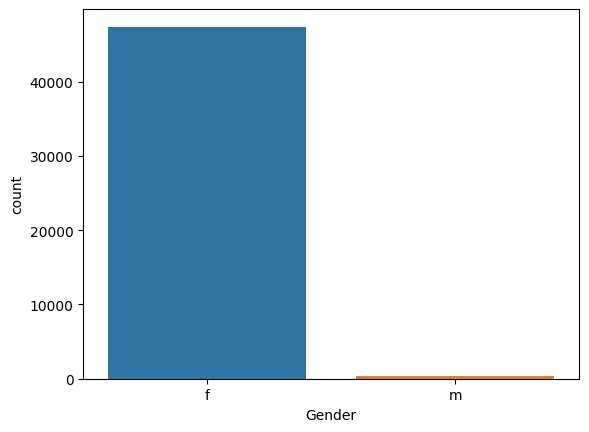

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data = df, x = 'Gender')

In [7]:
print(df.columns)

Index(['Datetime', 'OrderID', 'ProductID', 'Quantity', 'CategoryID',
       'CategoryCode', 'BrandID', 'USDPrice', 'UserID', 'Gender', 'Color',
       'Metal', 'Gem', 'Country'],
      dtype='object')


In [8]:
df.Gender.fillna('f', inplace=True)
df.info()
df.CategoryCode.fillna('other', inplace=True)
df['BrandID'].fillna('-1',inplace=True)
df['Gem'].unique()
for i in ('Color','Metal','Gem'):
  if i == 'Color':
    df[i].fillna('unknown-color',inplace=True)
  else:
    df[i].fillna('unknown',inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95911 entries, 0 to 95910
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      95911 non-null  object 
 1   OrderID       95911 non-null  float64
 2   ProductID     95911 non-null  float64
 3   Quantity      95794 non-null  float64
 4   CategoryID    90559 non-null  float64
 5   CategoryCode  85978 non-null  object 
 6   BrandID       91126 non-null  float64
 7   USDPrice      90559 non-null  float64
 8   UserID        90559 non-null  float64
 9   Gender        95911 non-null  object 
 10  Color         88251 non-null  object 
 11  Metal         90449 non-null  object 
 12  Gem           61853 non-null  object 
 13  Country       95911 non-null  object 
dtypes: float64(7), object(7)
memory usage: 10.2+ MB


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt


# Ensure that 'Datetime' is a datetime object and 'USDPrice' is float
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['USDPrice'] = df['USDPrice'].astype(float)

# Current date for recency calculation (assuming the latest date in the dataset + 1 day)
current_date = df['Datetime'].max() + dt.timedelta(days=1)

# RFM Calculation
rfm = df.groupby('UserID').agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'OrderID': 'count',                                   # Frequency
    'USDPrice': 'sum'                                     # Monetary
})

# Rename the columns
rfm.rename(columns={'Datetime': 'Recency',
                    'OrderID': 'Frequency',
                    'USDPrice': 'Monetary'}, inplace=True)

# KNN Customer Segmentation
# Standardize the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# KMeans to find clusters
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Displaying the first few rows of the RFM table with clusters
rfm.head()

,Recency,Frequency,Monetary,Cluster
UserID,,,,
1.310000e+18,21,277,102452.13,2
1.320000e+18,1,441,153919.99,4
1.330000e+18,10,321,120457.90,4
1.340000e+18,45,120,48179.17,2
1.350000e+18,22,74,19918.57,2


In [10]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assume you have determined the number of clusters to be 3 for 'top', 'medium', and 'low' segments
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the centroids to label the segments
centroids = kmeans.cluster_centers_
# Sort the centroids by Monetary value (or another criterion you deem important for segmentation)
sorted_idx = centroids[:, 2].argsort()

# Assign segment labels based on the sorted index
segment_labels = {sorted_idx[0]: 'Low', sorted_idx[1]: 'Medium', sorted_idx[2]: 'Top'}
rfm['Segment'] = rfm['Cluster'].map(segment_labels)

# You can now use the 'Segment' column in your plot or further analysis
fig = go.Figure(data=[go.Scatter3d(
    x=rfm['Recency'],
    y=rfm['Frequency'],
    z=rfm['Monetary'],
    mode='markers',
    marker=dict(
        size=5,
        color=rfm['Segment'].map({'Top': 'green', 'Medium': 'yellow', 'Low': 'red'}),  # color by segment
        opacity=0.8
    ),
    text=rfm.index  # UserIDs as hover text
)])

# Setting the layout for the 3D plot
fig.update_layout(
    title="RFM Segmentation with Top, Medium, and Low Segments",
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # tight layout
)

# Showing the figure
fig.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Convert 'Datetime' to datetime format and create additional time features
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year

# Aggregate data at the customer level
customer_df = df.groupby('UserID').agg(
    Total_Spend=('USDPrice', 'sum'),
    Average_Spend=('USDPrice', 'mean'),
    Total_Orders=('OrderID', 'nunique'),
    Total_Items=('Quantity', 'sum'),
    Recency=('Datetime', lambda x: (pd.Timestamp.now() - x.max()).days),
    # Include other features that might be relevant
).reset_index()

# Assuming you have another DataFrame 'rfm' with RFM scores already calculated
# customer_df = customer_df.merge(rfm, on='UserID', how='left')

# Create a dummy target variable for demonstration purposes
# In practice, this should be based on your specific business logic
customer_df['Will_Purchase_Next_Month'] = (customer_df['Total_Orders'] % 2).astype(int)

# Split the dataset into features (X) and target (y)
X = customer_df.drop(['UserID', 'Will_Purchase_Next_Month'], axis=1)
y = customer_df['Will_Purchase_Next_Month']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



In [13]:
import pandas as pd


# Check the distribution of the target class
class_distribution = df['CategoryCode'].value_counts()
print(class_distribution)


jewelry.earring     29052
jewelry.ring        28300
jewelry.pendant     13088
other                9933
jewelry.bracelet     6188
                    ...  
626.58                  1
13.42                   1
2.88                    1
101.23                  1
253.77                  1
Name: CategoryCode, Length: 219, dtype: int64


In [14]:
# Keep only rows where CategoryCode is a valid category
valid_categories = ['jewelry.earring', 'jewelry.ring', 'jewelry.pendant', 'other', 'jewelry.bracelet']  # Add other valid categories
df = df[df['CategoryCode'].isin(valid_categories)]

# Check the distribution again
print(df['CategoryCode'].value_counts())



jewelry.earring     29052
jewelry.ring        28300
jewelry.pendant     13088
other                9933
jewelry.bracelet     6188
Name: CategoryCode, dtype: int64


In [15]:
from sklearn.utils import resample

# Upsample minority classes
df_upsampled_list = []
majority_class_size = df['CategoryCode'].value_counts().max()

for category in valid_categories:
    df_category = df[df.CategoryCode == category]
    df_category_upsampled = resample(df_category,
                                     replace=True,
                                     n_samples=majority_class_size,
                                     random_state=123)
    df_upsampled_list.append(df_category_upsampled)

# Combine upsampled dataframes
df_upsampled = pd.concat(df_upsampled_list)

# Check new class distribution
print(df_upsampled.CategoryCode.value_counts())


jewelry.earring     29052
jewelry.ring        29052
jewelry.pendant     29052
other               29052
jewelry.bracelet    29052
Name: CategoryCode, dtype: int64


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame after addressing class imbalance

# Select columns for feature engineering
categorical_features = ['Gender', 'Color', 'Metal', 'Gem']  # Add other categorical columns
numerical_features = ['Quantity', 'USDPrice']  # Add other numerical columns

# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Create a column transformer to apply transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare features and target variable
X = df.drop(['CategoryCode', 'OrderID', 'ProductID', 'UserID', 'Datetime'], axis=1)
y = df['CategoryCode']


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Prepare features and target variable
X = df_upsampled.drop(['CategoryCode'], axis=1)  # Include relevant features
y = df_upsampled['CategoryCode']

# Encoding and scaling
categorical_features = ['Gender', 'Color', 'Metal', 'Gem']  # Update as per your dataset
numerical_features = ['Quantity', 'USDPrice']  # Update as per your dataset

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Prepare the features by selecting only numeric columns for scaling
numeric_features = customer_df.select_dtypes(include=['int64', 'float64'])

# Prepare the target variable
y = customer_df['Average_Spend']

# Drop the non-numeric and target columns from features
X = numeric_features.drop(['Total_Spend', 'Average_Spend'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 1666.104554933043
R2 Score: 0.2284364722267167


In [ ]:
import pandas as pd

# Filter the dataset to include only the relevant categories
categories = ['jewelry.bracelet', 'jewelry.earring', 'jewelry.pendant', 'jewelry.ring', 'other']
df_filtered = df[df['CategoryCode'].isin(categories)]

# Define features and target
features = ['Quantity', 'CategoryCode', 'Gender', 'Color', 'Metal', 'Gem']
target = 'USDPrice'



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define categorical and numerical features
categorical_features = ['CategoryCode', 'Gender', 'Color', 'Metal', 'Gem']
numerical_features = ['Quantity']

# Create transformers for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Prepare features and target variable
X = df_filtered.drop(target, axis=1)
y = df_filtered[target]



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Quantity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CategoryCode', 'Gender',
                                                   'Color', 'Metal',
                                                   'Gem'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
# Example user data for different types of jewelry
user_data_examples = [
    {'CategoryCode': 'jewelry.bracelet', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Gold', 'Metal': 'Gold', 'Gem': 'Diamond'},
    {'CategoryCode': 'jewelry.earring', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Silver', 'Metal': 'Silver', 'Gem': 'Diamond'},
    {'CategoryCode': 'jewelry.pendant', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Gold', 'Metal': 'Gold', 'Gem': 'Emerald'},
    {'CategoryCode': 'jewelry.ring', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Rose Gold', 'Metal': 'Rose Gold', 'Gem': 'Ruby'},
    {'CategoryCode': 'other', 'Quantity': 1, 'Gender': 'Unisex', 'Color': 'Multicolor', 'Metal': 'Mixed', 'Gem': 'None'}
]

# Predict for each type of jewelry
for user_data in user_data_examples:
    user_df = pd.DataFrame([user_data])
    predicted_spend = model.predict(user_df)
    print(f"Predicted amount to be spent on {user_data['CategoryCode']}: ${predicted_spend[0]:.2f}")



Predicted amount to be spent on jewelry.bracelet: $141.40
Predicted amount to be spent on jewelry.earring: $233.62
Predicted amount to be spent on jewelry.pendant: $301.05
Predicted amount to be spent on jewelry.ring: $347.99
Predicted amount to be spent on other: $194.89


In [ ]:
import pandas as pd

# Define the time frame for churn analysis
start_date = pd.Timestamp('2020-01-01')  # Start of the period
end_date = pd.Timestamp('2021-12-01')    # End of the period

# Identify active customers at the start of the period
active_customers = df[df['Datetime'] < start_date]['UserID'].unique()

# Identify customers who made purchases during the period
active_during_period = df[(df['Datetime'] >= start_date) &
                          (df['Datetime'] <= end_date)]['UserID'].unique()

# Identify customers who have churned
# Churned customers are those who were active before but not active during the period
churned_customers = set(active_customers) - set(active_during_period)

# Calculate churn rate
churn_rate = len(churned_customers) / len(active_customers) * 100

print(f"Customer Churn Rate: {churn_rate:.2f}%")


Customer Churn Rate: 0.00%


In [ ]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Apply K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(X_processed)

# Get the cluster labels
labels = kmeans.labels_

# Reduce dimensions for 3D visualization
svd = TruncatedSVD(n_components=3, random_state=42)
X_svd = svd.fit_transform(X_processed)


NameError: name 'X_processed' is not defined

In [ ]:
!pip install plotly


In [ ]:
# Create a 3D scatter plot using plotly
fig = go.Figure()

colors = ['blue', 'green', 'red', 'cyan', 'magenta']

for i in range(5):
    fig.add_trace(go.Scatter3d(
        x=X_svd[labels == i, 0],
        y=X_svd[labels == i, 1],
        z=X_svd[labels == i, 2],
        mode='markers',
        marker=dict(size=5, color=colors[i], opacity=0.8),
        name=f'Cluster {i+1}'
    ))

# Update plot layout
fig.update_layout(
    title='3D view of K-Means Clusters',
    scene=dict(
        xaxis_title='SVD Component 1',
        yaxis_title='SVD Component 2',
        zaxis_title='SVD Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()



In [ ]:
from sklearn.cluster import KMeans

# Assuming you have already processed your dataset into X_processed
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
df['Cluster_Labels'] = kmeans.fit_predict(X_processed)


In [ ]:
# Convert datetime columns to numeric (e.g., extracting year, month, day)
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day

# Drop the original datetime column
df = df.drop('Datetime', axis=1)

# Handle categorical data (e.g., using one-hot encoding)
categorical_columns = ['CategoryCode', 'Gender', 'Color', 'Metal', 'Gem']  # Update this list based on your dataset
df = pd.get_dummies(df, columns=categorical_columns)

# Now prepare your features (X) and target (y) again
X = df.drop(['Churn', 'Cluster_Labels'], axis=1)
y = df['Cluster_Labels']



In [ ]:
print(df.columns)

In [ ]:
# Prepare the features and target variable for cross-validation
X = df.drop(['Churn', 'Cluster_Labels'], axis=1)
y = df['Cluster_Labels']


In [ ]:

# Exclude non-numeric or unnecessary columns for the model
columns_to_exclude = ['Item_Features']  # Add any other non-numeric columns here
X = df.drop(columns_to_exclude + ['Churn', 'Cluster_Labels'], axis=1)
y = df['Cluster_Labels']


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5)

print("Cross-validation scores:", scores)
print("Average score:", scores.mean())


In [ ]:
df.info()
df.describe(include= 'all')

In [ ]:
df.head()

In [ ]:
df[['USDPrice']].describe()

In [ ]:
!pip install pandas numpy statsmodels


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


# Create a binary 'Purchase' indicator based on 'Quantity'
df['Purchase'] = np.where(df['Quantity'] > 0, 1, 0)

# Selecting relevant columns for the model
X = df[['USDPrice']]  # Predictor variable(s)
y = df['Purchase']    # Response variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the logistic regression model with regularization
model = sm.Logit(y, X)
result = model.fit_regularized(method='l1')  # L1 regularization



# Output the summary of the model
print(result.summary())

# Calculating elasticity
# Note: This is a simplification, as elasticity can vary across different price points
df['prob'] = result.predict(X)
df['elasticity'] = df['prob'] * (1 - df['prob']) * df['USDPrice']

# Average elasticity
avg_elasticity = df['elasticity'].mean()
print(f"Average Price Elasticity of Purchase Probability: {avg_elasticity}")



In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it contains 'USDPrice' and 'elasticity' columns
# Make sure to run the logistic regression and elasticity calculation code before this

plt.figure(figsize=(10, 6))
plt.scatter(df['USDPrice'], df['elasticity'], alpha=0.5)
plt.title('Price Elasticity of Purchase Probability')
plt.xlabel('Price (USD)')
plt.ylabel('Elasticity')
plt.grid(True)
plt.show()


In [ ]:
pip install pandas scikit-learn


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Create a binary 'Purchase' indicator based on 'Quantity'
df['Purchase'] = df['Quantity'].apply(lambda x: 1 if x > 0 else 0)

# Selecting features for the model
# You can add more features as needed
X = df[['USDPrice']]  # Predictor variable(s)
y = df['Purchase']    # Response variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the SVM model
model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly'
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np


df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)

# Sort the data by customer and date
df.sort_values(['UserID', 'Datetime'], inplace=True)

# Define a function to create sequences for each customer
def create_sequences(df, sequence_length):
    sequences = []
    targets = []
    customers = df['UserID'].unique()

    for customer in customers:
        customer_data = df[df['UserID'] == customer]
        for i in range(len(customer_data) - sequence_length):
            seq = customer_data.iloc[i:i+sequence_length]  # Sequence of purchases
            target = customer_data.iloc[i+sequence_length]  # Next purchase
            sequences.append(seq[['Quantity', 'USDPrice']].values)  # Example features
            targets.append(target['Quantity'])  # Example target
            # Note: Adjust the features and target as per your requirement

    return sequences, targets

# Define your sequence length
sequence_length = 10  # For example, last 10 transactions

# Create sequences and targets
X, y = create_sequences(df, sequence_length)

# Example: Convert X and y into suitable formats for training
# Normalize X if needed
# X = [MinMaxScaler().fit_transform(seq) for seq in X]

# Convert the list of sequences into a numpy array for RNN training
# X = np.array(X)

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
